# <a href="http://www.datascience-paris-saclay.fr">Paris Saclay Center for Data Science</a>
# RAMP on learning a surrogate for a macroeconomic agent-based model

<i> Balázs Kégl (LAL/CNRS), Amir Sani ([Centre d'Économie de la Sorbonne](http://centredeconomiesorbonne.univ-paris1.fr/), [Paris School of Economics](http://www.parisschoolofeconomics.eu/en/)), Francesco Lamperti (Scuola Superiore Sant'Anna, Pisa/Université Paris 1), and Antoine Mandel ([Centre d'Économie de la Sorbonne](http://centredeconomiesorbonne.univ-paris1.fr/), [Paris School of Economics](http://www.parisschoolofeconomics.eu/en/)) </i> 

Funding support is provided by the European Union Horizons 2020 Future and Emerging Technologies Distributed Global Financial Systems for Society (DOLFINS) project.

## Introduction

### Agent-based models in macroeconomy

Standard, __neoclassical macroeconomics__ models build upon a set of rather unrealistic assumptions. The economy is populated by __a unique infinitely-lived representative household__, who maximizes its utility under an intertemporal budget constraint, and by a large number of firms, whose __homogenous production__ technology is hit by exogenous shocks. All agents form their expectations __rationally__ (their forecasts are, on average, right), and the central bank may influence the real economy in the short run by __modifying the interest rate__. Interactions of agents are confined to markets. These assuptions allow the __analytical tractability__ of the model, which is usually composed of few equations that are (log) linearized around a single fixed point. The economy is then usually perceived as a system in __stable equilibrium__ that might be exogenously shocked. Economic fluctuations are the result of the adjustment process that pushes back the economy to its "natural" equilibrium.

An __agent-based model (ABM)__ is a computational (__simulation__) tool used to study the behaviour of complex systems composed of multiple agents that are possibly __heterogenous__ in all their characteristics, __boundedly rational__ (especially in economic applications), and __interacting__ with each other. Equilibria might be multiple or even do not exist. Emergent properties at the population level are arising naturally from agent interactions. These could not be deduced simply by aggregating individual properties. This a defining characteristic (and advantage) of ABMs.

Unlike top-down models, ABMs __model the behavior of agents and interactions__. The number of parameters and the complex relationships between agents make it impossible to derive analyticial expressions to explain economic observables, typically time series of various quantities (stock prices, unemployment, etc.). Often it is even impossible to numerically compute likelihoods. As in many other _computational_ scientific fields (particle physics, epidemiology, molecular genetics), the solution is to implement bottom-up __simulators__. Simulators take a set of __parameters__ $\theta$ as input and produce economic observables $\mathbf{x} = g(\theta)$ that can be compared to real observables. Typical parameters can be exogeneous/control (e.g., the base interest rate), or may be describing the behavior of given agents in economic transactions (e.g., risk aversion). Typical observables are time series of empirical quantitities, such as, in our case, the daily returns of a financial asset.

There are two slightly different scenarios where economists use ABM simulators.
<ol>
<li> __Inference__. Given a real observable $\mathbf{x}$, find a parameter vector $\widehat{\theta}$ that generated $\mathbf{x}$. Economists call this <i>calibration</i>, in this note we will use the more common term of statistical <i>inference</i>. Since neither the posterior $p(\theta | \mathbf{x})$ nor the likelihood $p(\mathbf{x} | \theta)$ are known or computable, ecomomists usually use a stochastic optimization loop to optimize a custom-made similarity function $S(\mathbf{x}, \mathbf{x^\prime})$. Most of the time the optimization consists in randomly sampling $\{\theta_i\}_{i=1}^n$ from a prior $p(\theta)$, simulating the corresponding observables $\mathbf{x}_i = g(\theta_i)$ and selecting either
$$\widehat{\theta} = \mathop{\mathrm{arg\,max}}_{\theta_i} S\big(\mathbf{x}, g(\theta_i)\big),$$
or a set
$$\widehat{\Theta} = \big\{\theta_i : S\big(\mathbf{x}, g(\theta_i)\big) > s \big\},$$
where $s$ is a pre-defined threshold.</li>
<li> <b>Control / experimental design</b>. Once $\widehat{\theta}$ or $\widehat{\Theta}$ has been found, the usual goal of _policy makers_ is to explore possible policies around $\widehat{\theta}$ or for all $\widehat{\theta} \in \widehat{\Theta}$. They consider that the inference procedure identified the correct model parameters (e.g., parameters that describe the agents) in $\widehat{\theta}$, and their goal is to explore possible policies related to setting some of the exogenous _control_ parameters in $\widehat{\theta}$, such as the base interest rate, within reasonable limits. In principle, this technique could also be used for __optimizing__ the policy for a desired outcome $\mathbf{x^*}$.
</ol>

There are essentially two reasons why simulation-based policy making has not yet been widely adopted. First, inference, especially if using random sampling, may take __considerable computational resources__ to run. Most economists have neither access to such resources, nor the __technical expertise__ to run the simulators on them. Second, before running the simulator in the control/optimization setup, the economist wants to be absolutely sure that the simulator is __valid in the region of the parameter space into which it is driven by the control procedure__. It is by definition valid at $\widehat{\theta}$ or in $\widehat{\Theta}$ (since at those parameters it produced a realistic scenario $\mathbf{x}_i$ with large $S(\mathbf{x}, \mathbf{x}_i)$), but the economist's fear is that slight changes of $\widehat{\theta}$ will make the simulator behave in an unpredictible way, producing irrealistic observables. What makes an observable irrealistic can sometimes be decided objectively (e.g., negative unemployment rate), but often it is based on subjective expert judgement of the economist. This makes this robustness problem (they call the _knife-edge feature_) somewhat difficult to formalize.

### The formal learning problem

The goal of this RAMP is to __learn a surrogate__ $f$ that maps $\theta$ to $S\big(\mathbf{x}, g(\theta)\big)$. More precisely, we set it up as a __binary classification__ problem where the goal is to predict the _acceptability_ $\mathbb{1}\big\{S\big(\mathbf{x}, g(\theta)\big) > s\big\}$ of $\theta$. Since most of the random $\theta$s do not produce acceptable observables $\mathbf{x}$, the problem is __highly unbalanced__. The original ABM used for simulating the data produced about $20$ positives for a millon negatives. To make the problem feasible for a single-day event, we had to tune the data size for a reasonable training time and the evaluation metrics to a small enough variance. We achieved this by oversampling the positive region.

Such a classifier may be used as the surrogate in stochastic optimization or approximate Bayesian computation, but at this point the main use case is the control / experimental design setup: it allows policy makers to rapidly explore different policies without running the computationally heavy simulator.

### The concrete ABM and training data

The  <a href="http://www.sciencedirect.com/science/article/pii/S0165188998000116"> concrete ABM </a> we chose for this RAMP is a rather simple one. It has 10 parameters $\theta$. It is an __asset pricing model with heterogenous traders__ that generates daily returns $\mathbf{x}$ for a year (250 days). The distribution of the returns is compared to the real distribution in the SP500. We then run a <a href="https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test#Two-sample_Kolmogorov.E2.80.93Smirnov_test">two-sample Kolmogorov-Smirnov test</a> and compute the p-value which acts as our similarity function $S(\mathbf{x}, \mathbf{x^\prime})$. The goal is to find test points $\theta_i$ with $p = S\big(\mathbf{x}, g(\theta_i)\big) > 0.05$.

The parameter vector contains the following elements, acting as features for the learning problem.
<ul>
  <li> <code><b>switching_parameter</b></code>: represents traders' attitude towards switching their strategy and answers to the question: how much traders trust the information (expectation) about other agents' performances. In some sense, it measures the "imitative behavior" (if 0, then traders distribute evenly across strategies; if infinite, all traders adopt the strategy with the highest fitness).
  <li> <code><b>rational_expectation_cost</b></code>: the cost of obtaining a good (on average right) forecast.
  <li> <code><b>risk_free_return</b></code>: return of a risk free (e.g., US treasury bond) asset.
  <li> <code><b>weight_past_profits</b></code>: the relative importance of past (accumulated) profits in determing the fitness strategy of the agents.
  <li> <code><b>delta</b></code>: bias of an agent towards type 1's strategy (if 0, no bias; if 1, type 1 agents do not change strategy, independently of its fitness).
  <li> <code><b>alpha</b></code>: risk aversion, which is assumed to be equal for all traders (larger values correspond to larger risk aversion).
  <li> <code><b>bias_1</b></code>: bias of trader 1's forecast about next period's price.
  <li> <code><b>trend_1</b></code>: trend component of trader 1's forecast about next period price (if positive, trend chaser; if negative, trend contrarian).
  <li> <code><b>bias_2</b></code>: bias component of trader 2's forecast about next period's price.
  <li> <code><b>trend_2</b></code>: trend component of trader 2's forecast about next period price (if positive, trend chaser; if negative, trend contrarian).
</ul>

In the target we will provide the p-value. The goal of the predictor is to classify to $1$ those with <code>p-value</code>$ > 0.001$, and to classify the rest to $0$. We will measure the performance of the classifier by the <a href="https://en.wikipedia.org/wiki/F1_score">F1 score</a> of the positive class, which is the harmonic mean of <a href=https://en.wikipedia.org/wiki/Precision_(information_retrieval)>precision</a> and <a href=https://en.wikipedia.org/wiki/Precision_and_recall>recall</a>.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## Fetch the data and load it in pandas

In [2]:
data = pd.read_csv('data/public/public_train.csv')

In [3]:
data.shape

(59801, 11)

In [4]:
data.tail()

,switching_parameter,rational_expectation_cost,risk_free_return,weight_past_profits,delta,alpha,bias_1,trend_1,bias_2,trend_2,p-value
59796,3.5,5,1.06,0.09,0.23,98,1.0,0.5,0.9,0.1,5.763535e-11
59797,7.1,4,1.08,0.38,0.00,14,1.4,-1.3,1.7,-0.2,8.382311e-12
59798,6.9,5,1.05,0.22,0.86,5,1.2,-0.1,1.1,0.1,3.681411e-10
59799,9.5,2,1.08,0.16,0.42,3,1.8,0.0,1.8,-0.1,2.000452e-10
59800,8.4,2,1.04,0.14,0.47,79,1.7,0.1,1.1,0.1,2.092492e-08


In [5]:
p_threshold = 0.001

In [6]:
data_good = data[data['p-value'] > p_threshold]
data_good.shape

(713, 11)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1091c78d0>]], dtype=object)

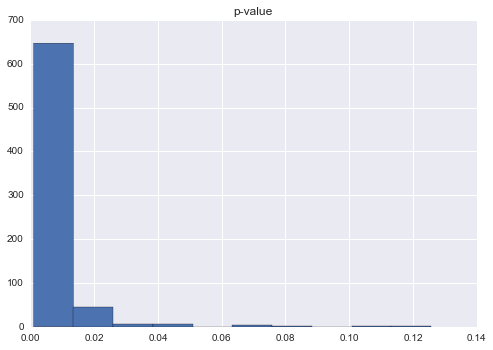

In [7]:
data_good.hist('p-value')

In [8]:
data.describe()

,switching_parameter,rational_expectation_cost,risk_free_return,weight_past_profits,delta,alpha,bias_1,trend_1,bias_2,trend_2,p-value
count,59801.000000,59801.000000,59801.000000,59801.00000,59801.000000,59801.000000,59801.000000,59801.000000,59801.000000,59801.000000,5.980100e+04
mean,6.247957,2.850337,1.054754,0.49893,0.522147,55.039096,1.395813,-0.215458,1.269297,0.173878,7.843374e-05
std,2.198966,1.602937,0.028706,0.29036,0.331606,27.552177,0.437008,0.704790,0.522153,0.443240,1.280562e-03
min,2.500000,0.000000,1.010000,0.00000,0.000000,1.000000,-0.800000,-2.000000,-0.500000,-2.000000,7.976250e-79
25%,4.300000,2.000000,1.030000,0.25000,0.210000,32.000000,1.100000,-0.600000,0.900000,-0.100000,1.607044e-11
50%,6.300000,3.000000,1.050000,0.50000,0.530000,57.000000,1.400000,-0.200000,1.300000,0.100000,1.216523e-09
75%,8.100000,4.000000,1.080000,0.75000,0.840000,79.000000,1.700000,0.200000,1.700000,0.400000,1.045499e-07
max,10.000000,5.000000,1.100000,1.00000,1.000000,100.000000,2.000000,2.000000,2.000000,2.000000,1.256482e-01


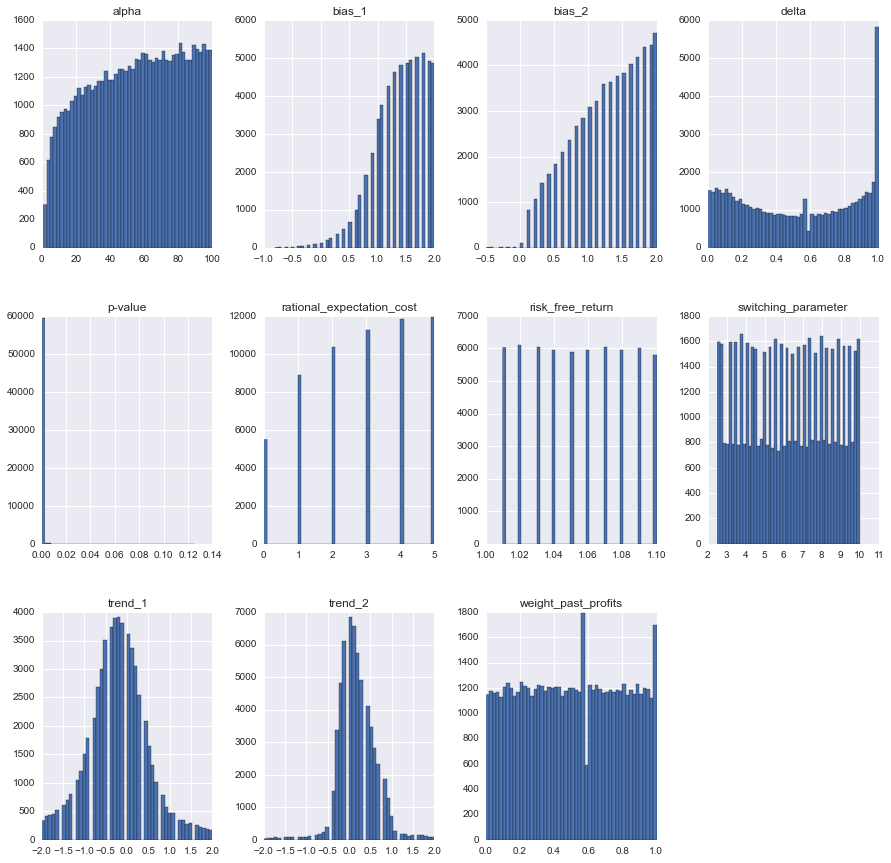

In [9]:
data.hist(figsize=(15, 20), bins=50, layout=(4, 4)); 

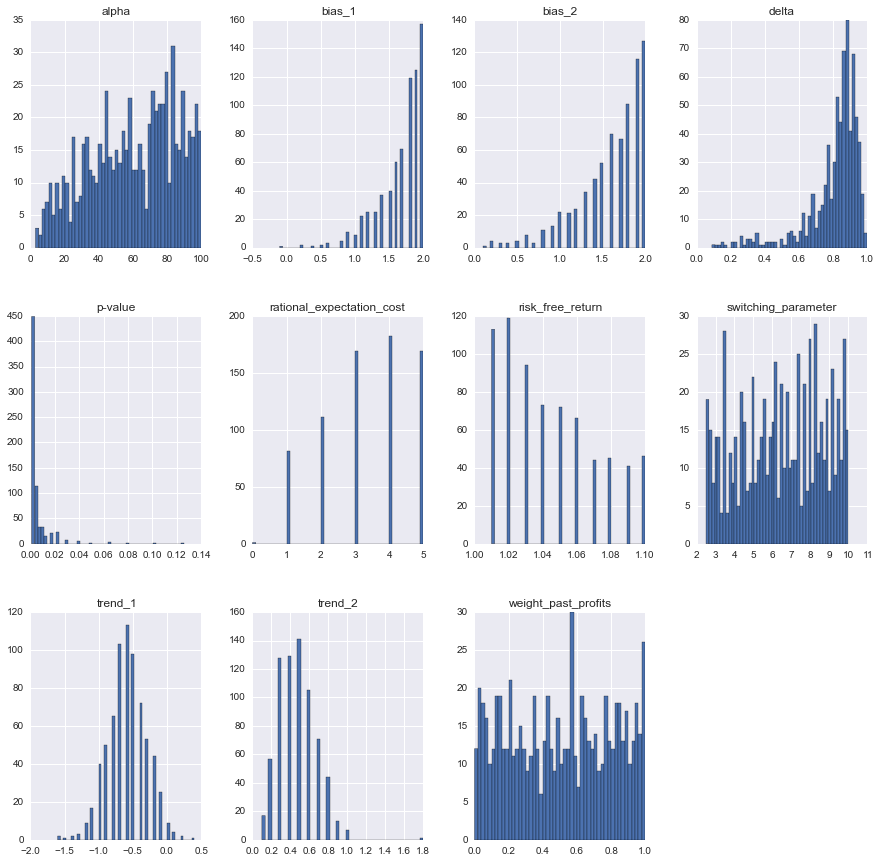

In [10]:
data_good.hist(figsize=(15, 20), bins=50, layout=(4, 4));

/Users/kegl/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


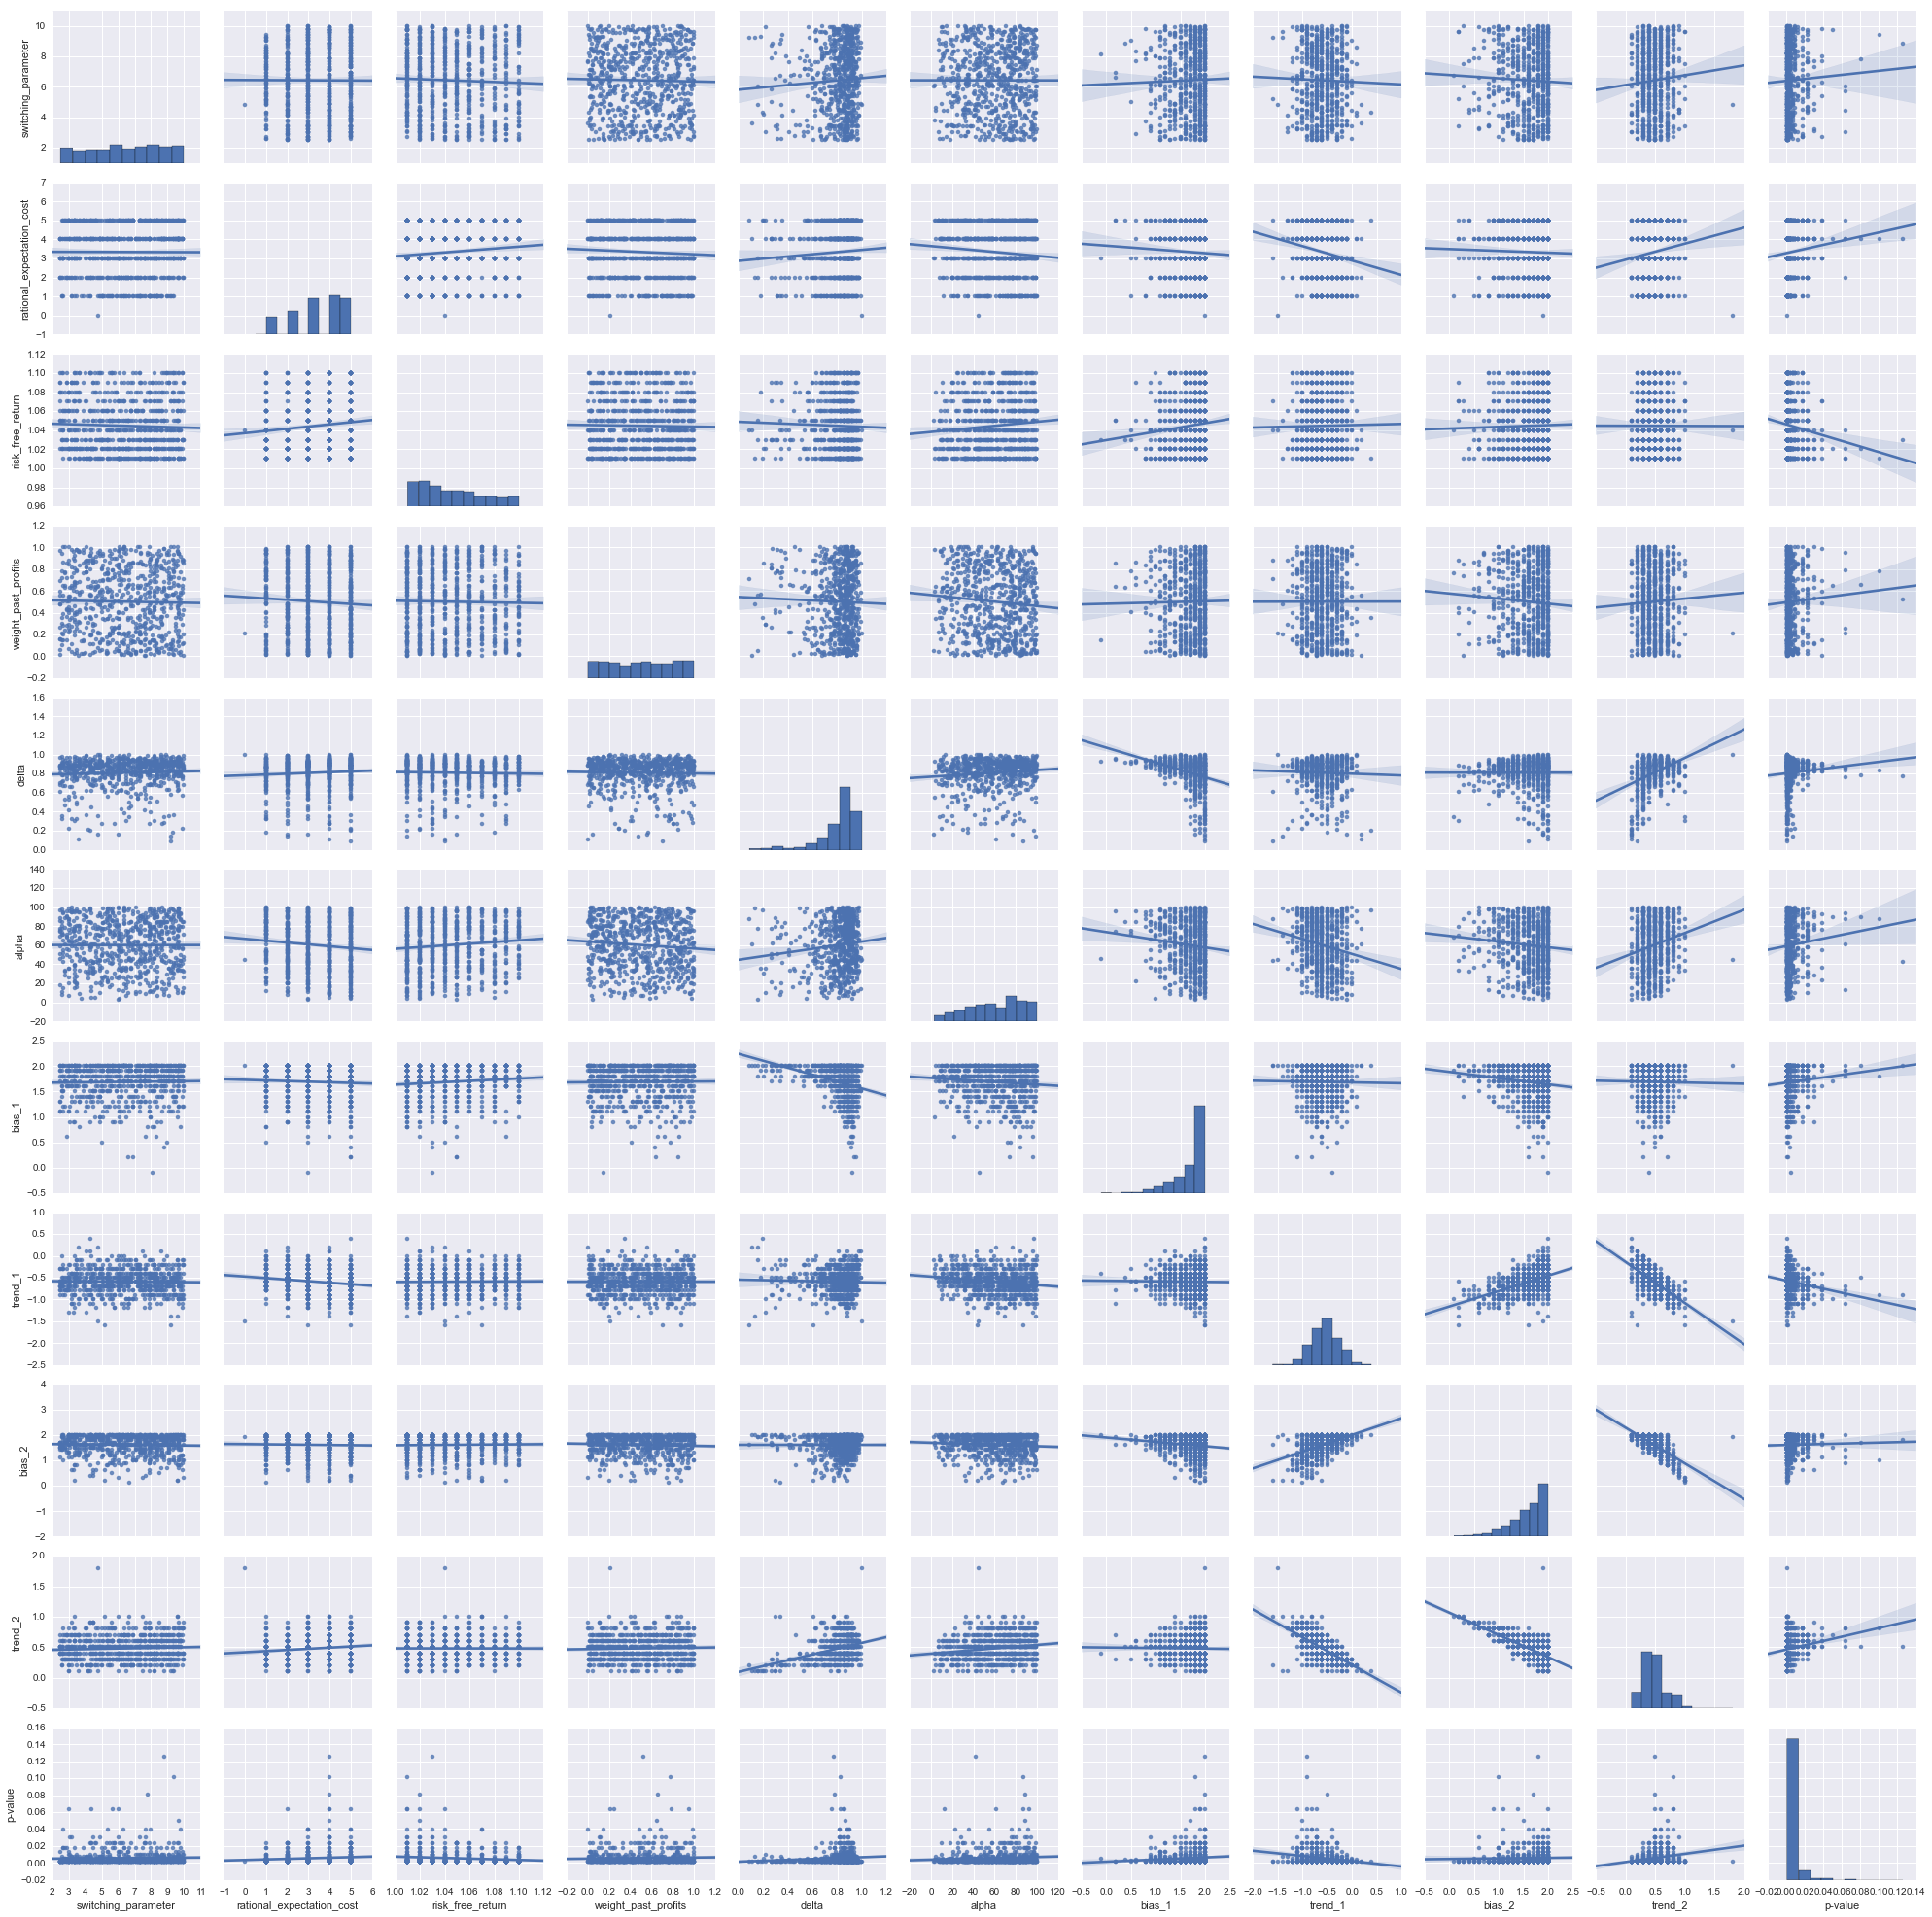

In [11]:
sns.pairplot(data_good, kind='reg');

## Building predictive models

### The score

You will be expected to submit a regressor with a fit and predict function that returns a real-valued prediction vector. Both the real p-value and your prediction will be thresholded at 0.001, and you will be evaluated using the F1 score on the positive point.

In [12]:
from sklearn.metrics import f1_score

def score(y_test, y_pred):
    return f1_score(y_test > p_threshold, y_pred > p_threshold)

We first make standard train and test files.

In [13]:
from sklearn.cross_validation import train_test_split

features = data.drop(['p-value'], axis=1)
X = features.values.astype(np.float32)
y = data['p-value'].values.astype(np.float32)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=0)

### Tackling the problem using a classifier

In the first approach, you can tackle the problem as a classification. First, you have to choose a threshold for labeling the training set. You may use the evaluation threshold 0.001, but you can also make the problem more balanced by choosing another threshold.

In [15]:
y_train_c = y_train > 0.0005

Let's learn a random forest

In [16]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=50, max_leaf_nodes=200)
clf.fit(X_train, y_train_c);

The evaluation will be invariant to any transformation that keeps the thresholded labels unchanged, so you may be tempted to use the predict function and return a binary prediction. We suggest that you use instead the predict_proba function because your predictor will behave better in our blending scheme that determines your contributivity score.

In [17]:
y_pred_proba = clf.predict_proba(X_test)[:, 1]

You will probably have to calibrate your prediction because the fixed threshold 0.001 does not necessarily give you the optimal F1 score. 

/Users/kegl/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kegl/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


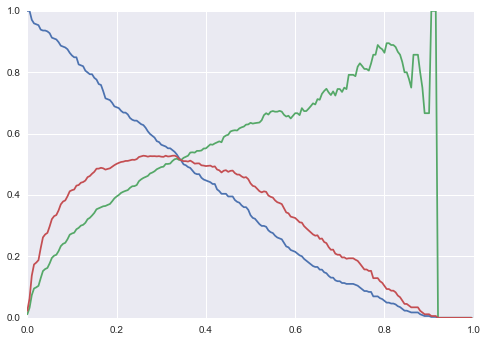

In [26]:
from sklearn.metrics import recall_score, precision_score

y_test_c = y_test > p_threshold

thresholds = np.arange(0.0, 1.0, 0.005)
recall_scores = [recall_score(y_test_c, y_pred_proba > threshold) for threshold in thresholds]
precision_scores = [precision_score(y_test_c, y_pred_proba > threshold) for threshold in thresholds]
f1_scores = [score(y_test, y_pred_proba * p_threshold / threshold) for threshold in thresholds]

plt.plot(thresholds, recall_scores)
plt.plot(thresholds, precision_scores)
plt.plot(thresholds, f1_scores);

Here is your final regressor.

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator


class Regressor(BaseEstimator):
    def __init__(self):
        self.clf = RandomForestClassifier(n_estimators=30, max_leaf_nodes=10)

    def fit(self, X, y):
        self.clf.fit(X, y > 0.0005)

    def predict(self, X):
        return self.clf.predict_proba(X)[:, 1] * 0.001 / 0.3


In [28]:
reg = Regressor()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print score(y_test, y_pred)

0.36398467433


### Tackling the problem using a regressor

In the second approach, you can tackle the problem as a regression. YOu may want to upweight points with higher p-values to concentrate more capacity to the positive region. 

In [29]:
from sklearn.ensemble import RandomForestRegressor

clf = RandomForestRegressor(n_estimators=100, max_leaf_nodes=100)
clf.fit(X_train, y_train, sample_weight=y_train+1);

In [30]:
y_pred = clf.predict(X_test);

In [31]:
print score(y_test, y_pred)

0.453551912568


Here is your final regressor.

In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator


class Regressor(BaseEstimator):
    def __init__(self):
        self.clf = RandomForestRegressor(n_estimators=100, max_leaf_nodes=100)

    def fit(self, X, y):
        self.clf.fit(X, y, sample_weight=y + 1)

    def predict(self, X):
        return self.clf.predict(X)


## Unit testing

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. For this we provide a unit test. Place the python files <code>regressor.py</code> and <a href = ""><code>user_test_model.py</code></a> in a directory, set the paths to the data files in <code>user_test_model.py</code>, and run 

<code>python user_test_model.py</code>

If it runs and prints 
<code>
Reading file ...
Training model ...
f1 = [some_number_between_0_and_1]
f1 = [some_number_between_0_and_1]
</code>
you can submit the code.